In [1]:
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from keras.models import *
from keras.layers import *

from keras.utils import *
from keras.callbacks import *
from keras.applications.densenet import DenseNet121, preprocess_input

import numpy as np
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import os
import xml.etree.ElementTree as ET

from skimage.io import imread
from PIL import Image

## Проверка данных

In [2]:
dataset_folder_path = "D:/datasets/stanford-dogs-dataset"
img_folders_path = dataset_folder_path + "/images/Images"
cropped_path = dataset_folder_path + "/cropped"
annots_path = dataset_folder_path + "/annotations/Annotation"

breed_dirs_list = os.listdir(img_folders_path)

num_classes = len(breed_dirs_list)
print("{} пород".format(num_classes))

num_total_images = 0

for breed_dir in breed_dirs_list:
    num_total_images += len(os.listdir(img_folders_path + "/{}".format(breed_dir)))

print("{} изображений всего".format(num_total_images))

dir_idx_map = {}
idx_dir_map = {}

for i, v in enumerate(breed_dirs_list):
    dir_idx_map.update({v : i})
    idx_dir_map.update({i : v})

120 пород
20580 изображений всего


n02116738-African_hunting_dog


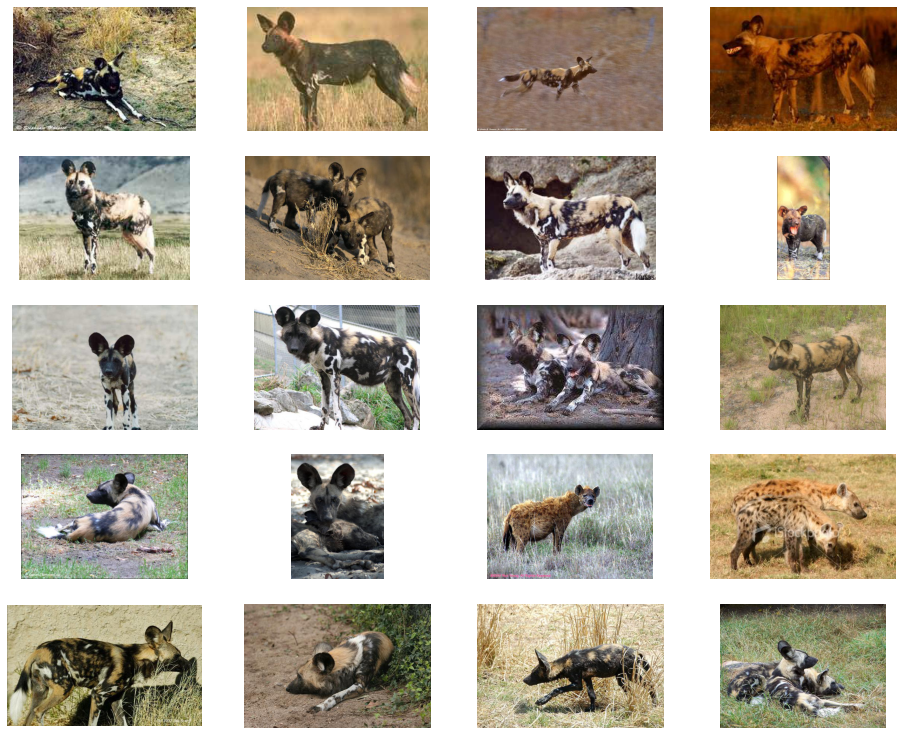

In [3]:
def print_imgs(dir_name, num_to_show):
    plt.figure(figsize=(16,16))
    
    dir_with_imgs = (img_folders_path + "/{}").format(dir_name)
    imgs = os.listdir(dir_with_imgs)[:num_to_show]
    
    rows_num = num_to_show/4+1
    cols_num = 4
    for i in range(num_to_show):
        img = mpimg.imread(dir_with_imgs + "/" + imgs[i])
        
        position = i+1
        plt.subplot(rows_num, cols_num, position)
        plt.imshow(img)
        plt.axis("off")

idx=119
print(breed_dirs_list[idx])
print_imgs(breed_dirs_list[idx], 20)

## Предобработка данных

Обрезаем изображение, оставляем только прямоугольник с собачкой.

In [10]:
os.mkdir(cropped_path)

for breed_dir in breed_dirs_list:
    os.mkdir(cropped_path + "/" + breed_dir)

cropped_dirs_list = os.listdir(cropped_path)
print("создано {} папок для хранения обрезанных изображений собак по породам".format(len(cropped_dirs_list)))

создано 120 папок для хранения обрезанных изображений собак по породам


In [11]:
%%time

for breed_name in cropped_dirs_list:
    for file in os.listdir(annots_path + "/{}".format(breed_name)):
        img = Image.open(img_folders_path + "/{}/{}.jpg".format(breed_name, file))
        
        tree = ET.parse(annots_path + "/{}/{}".format(breed_name, file))
        xmin = int(tree.getroot().findall("object")[0].find("bndbox").find("xmin").text)
        xmax = int(tree.getroot().findall("object")[0].find("bndbox").find("xmax").text)
        ymin = int(tree.getroot().findall("object")[0].find("bndbox").find("ymin").text)
        ymax = int(tree.getroot().findall("object")[0].find("bndbox").find("ymax").text)
        
        img = img.crop((xmin, ymin, xmax, ymax))
        img = img.convert("RGB")
        img = img.resize((224, 224))
        img.save(cropped_path + "/" + breed_name + "/" + file + ".jpg")

Wall time: 8min 36s


## Подготовка X и y

In [3]:
def paths_labels_targets():
    paths = list()
    labels = list()
    targets = list()
    
    for breed_name in breed_dirs_list:
        curr_breed_path = cropped_path + "/{}".format(breed_name)
        
        for img_name in os.listdir(curr_breed_path):
            paths.append(curr_breed_path + "/" + img_name)
            labels.append(breed_name)
            targets.append(dir_idx_map[breed_name])
    
    return paths, labels, targets

paths, labels, targets = paths_labels_targets()

assert len(paths) == len(labels)
assert len(paths) == len(targets)

targets = to_categorical(targets, num_classes=num_classes)
targets.shape

(20580, 120)

## Image Generator

In [4]:
class ImageGenerator(Sequence):
 
    def __init__(self, paths, targets, batch_size, shape):
        self.paths = paths
        self.targets = targets
        self.batch_size = batch_size
        self.shape = shape
          
    def __getitem__(self, batch_idx):
        start_path_idx = batch_idx * self.batch_size
        end_path_idx = (batch_idx + 1) * self.batch_size
        batch_paths = self.paths[start_path_idx : end_path_idx]
        
        X = np.zeros((len(batch_paths), 
                      self.shape[0], self.shape[1], self.shape[2]), 
                     dtype=np.float32)

        for i, path in enumerate(batch_paths):
            img = imread(path)
            img = preprocess_input(img)
            X[i] = img

        y = self.targets[start_path_idx : end_path_idx]
        
        return X, y

    def __iter__(self):
        for item in (self[i] for i in range(len(self))):
            yield item
                   
    def __len__(self):
        return int(np.ceil(len(self.paths) / float(self.batch_size)))

## Данные для обучения и для валидации

In [5]:
train_paths, valid_paths, train_targets, valid_targets = train_test_split(paths,
                                                                          targets,
                                                                          test_size=0.15,
                                                                          random_state=42)

train_gen = ImageGenerator(train_paths, train_targets, batch_size=32, shape=(224,224,3))
valid_gen = ImageGenerator(valid_paths, valid_targets, batch_size=32, shape=(224,224,3))

## Проверка видеокарты

https://www.tensorflow.org/install/gpu

In [6]:
sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(log_device_placement=True))

Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1



In [39]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Граф модели в формате PNG

In [7]:
#from keras.utils import plot_model
#plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

## Предобученная модель DenseNet121

In [7]:
img_input = Input((224, 224, 3))

densenet_model = DenseNet121(input_tensor=img_input,
                       weights="imagenet",
                       include_top=False)

x = densenet_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
classes_output = Dense(num_classes, activation="softmax")(x)

model = Model(img_input, classes_output)

for layer in model.layers[:-6]:
    layer.trainable = False

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

## Обучение

In [9]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["acc"])

checkpoint = ModelCheckpoint("dog-breed-classifier-densenet121.h5", 
                             monitor="val_acc", 
                             verbose=1, 
                             save_best_only=True, 
                             mode="max")

reduce_lr = ReduceLROnPlateau(monitor="val_loss", 
                              factor=0.2,
                              patience=1, 
                              verbose=1, 
                              mode="min",
                              min_delta=0.0001, 
                              cooldown=2, 
                              min_lr=1e-7)

early_stop = EarlyStopping(monitor="val_loss", 
                           mode="min",
                           patience=5)

In [10]:
%%time

history = model.fit_generator(generator=train_gen, 
                              steps_per_epoch=len(train_gen), 
                              validation_data=valid_gen, 
                              validation_steps=len(valid_gen),
                              epochs=20,
                              callbacks=[checkpoint, reduce_lr, early_stop])

Epoch 1/20
547/547 [==============================] - 637s 1s/step - loss: 3.2600 - acc: 0.2620 - val_loss: 0.7307 - val_acc: 0.7677

Epoch 00001: val_acc improved from -inf to 0.76774, saving model to dog-breed-classifier-densenet121.h5
Epoch 2/20
547/547 [==============================] - 140s 255ms/step - loss: 1.1583 - acc: 0.6475 - val_loss: 0.5924 - val_acc: 0.7959

Epoch 00002: val_acc improved from 0.76774 to 0.79592, saving model to dog-breed-classifier-densenet121.h5
Epoch 3/20
547/547 [==============================] - 139s 255ms/step - loss: 0.9440 - acc: 0.7086 - val_loss: 0.5293 - val_acc: 0.8325

Epoch 00003: val_acc improved from 0.79592 to 0.83252, saving model to dog-breed-classifier-densenet121.h5
Epoch 4/20
547/547 [==============================] - 137s 250ms/step - loss: 0.8511 - acc: 0.7352 - val_loss: 0.5301 - val_acc: 0.8244

Epoch 00004: val_acc did not improve from 0.83252

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch

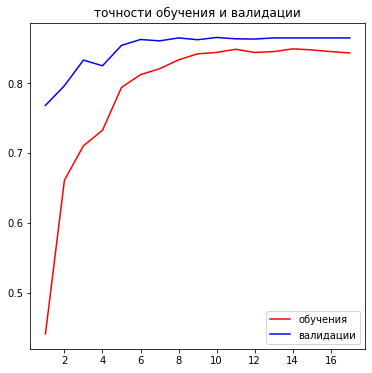

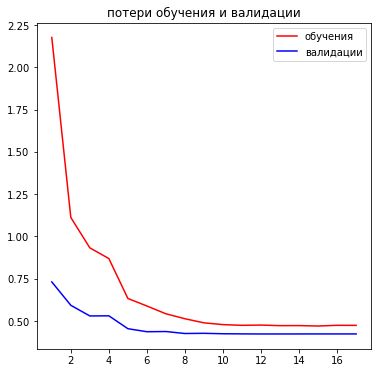

In [11]:
plt.rcParams["figure.figsize"] = (6,6)

plt.title("точности обучения и валидации")
acc = history.history["acc"]
epochs = range(1, len(acc) + 1)
val_acc = history.history["val_acc"]
plt.plot(epochs, acc, "red", label='обучения')
plt.plot(epochs, val_acc, "blue", label="валидации")
plt.legend()

plt.figure()
plt.title("потери обучения и валидации")
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.plot(epochs, loss, "red", label="обучения")
plt.plot(epochs, val_loss, "blue", label="валидации")
plt.legend()

plt.show()

In [12]:
print(max(val_acc))

0.8649173974990845


## Предсказание

In [25]:
import json

def read_json(file_name: str):
    with open(file_name) as file_in:
        return json.load(file_in)
    
def predict(file_name):
    img = Image.open(file_name)
    img = img.convert("RGB")
    img = img.resize((224, 224))
    img.save(file_name)

    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis("off")

    img = imread(file_name)
    img = tf.keras.applications.densenet.preprocess_input(img)
    img = tf.expand_dims(img, axis=0)
    probs = model.predict(img)
    
    for idx in probs.argsort()[0][::-1][:5]:
        print("{:.2f}%".format(probs[0][idx]*100), "\t", breed_names_map[str(idx)])

def download_and_predict(url, file_name):
    os.system("curl -s {} -o {}".format(url, file_name))
    predict(file_name)
    
breed_names_path = "D:/YandexDisk/models/dog-breed-classifier.json"
breed_names_map = read_json(breed_names_path)

99.98% 	 pomeranian
0.00% 	 pekinese
0.00% 	 toy_poodle
0.00% 	 chihuahua
0.00% 	 chow


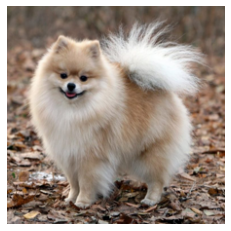

In [26]:
download_and_predict("https://i.imgur.com/QzxTOG1.jpg",
                     "pomeranian.jpg")

98.75% 	 doberman
1.01% 	 miniature_pinscher
0.18% 	 tan_coonhound
0.04% 	 toy_terrier
0.01% 	 kelpie


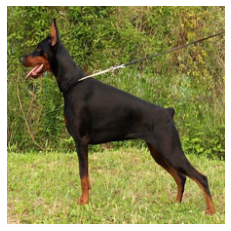

In [27]:
download_and_predict("https://upload.wikimedia.org/wikipedia/commons/7/7a/European_Dobermann.jpg",
                     "doberman.jpg")

99.27% 	 pug
0.33% 	 bull_mastiff
0.12% 	 brabancon_griffon
0.08% 	 norwegian_elkhound
0.07% 	 french_bulldog


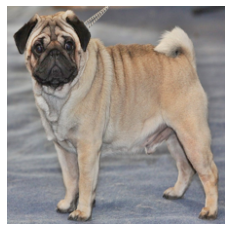

In [28]:
download_and_predict("https://upload.wikimedia.org/wikipedia/commons/f/f0/Mops_oct09_cropped2.jpg",
                     "pug.jpg")

100.00% 	 chow
0.00% 	 samoyed
0.00% 	 tibetan_mastiff
0.00% 	 pomeranian
0.00% 	 keeshond


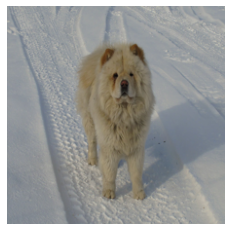

In [29]:
download_and_predict("https://upload.wikimedia.org/wikipedia/commons/c/c7/ChowChow1.jpg",
                     "chow.jpg")

## Предобученная модель VGG16

In [17]:
from keras.applications.vgg16 import VGG16, preprocess_input

img_input = Input((224, 224, 3))

vgg16_model = VGG16(input_tensor=img_input,
                    weights = 'imagenet',
                    include_top=False)

for layer in vgg16_model.layers:
    layer.trainable = False
    
for layer in vgg16_model.layers:
    print(layer,layer.trainable)

model = Sequential()
model.add(vgg16_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(4096, activation="relu"))
model.add(Dense(4096, activation="relu"))
model.add(Dense(num_classes,activation='softmax'))

model.summary()

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x000002AFC3016850> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002AFC3016C40> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002AFC3016A90> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000002AFC301BCA0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002AFC3059B20> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002AFC3052280> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000002AFC3068F40> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002AFC308E430> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002AFC30AFAF0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x000002AFC3097B80> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x000002AFC30A63A0> False
<tensorflow.python.

In [13]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["acc"])

checkpoint = ModelCheckpoint("dog-breed-classifier-vgg16.h5", 
                             monitor="val_acc", 
                             verbose=1, 
                             save_best_only=True, 
                             mode="max")

reduce_lr = ReduceLROnPlateau(monitor="val_loss", 
                              factor=0.2,
                              patience=1, 
                              verbose=1, 
                              mode="min",
                              min_delta=0.0001, 
                              cooldown=2, 
                              min_lr=1e-7)

early_stop = EarlyStopping(monitor="val_loss", 
                           mode="min",
                           patience=5)

In [20]:
%%time

history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen), 
                    validation_data=valid_gen, 
                    validation_steps=len(valid_gen),
                    epochs=20,
                    callbacks=[checkpoint, reduce_lr, early_stop])

Epoch 1/20
547/547 [==============================] - 254s 460ms/step - loss: 4.5585 - acc: 0.3041 - val_loss: 1.4911 - val_acc: 0.5863

Epoch 00001: val_acc improved from -inf to 0.58633, saving model to dog-breed-classifier-vgg16.h5
Epoch 2/20
547/547 [==============================] - 173s 317ms/step - loss: 2.1748 - acc: 0.4756 - val_loss: 1.2857 - val_acc: 0.6378

Epoch 00002: val_acc improved from 0.58633 to 0.63784, saving model to dog-breed-classifier-vgg16.h5
Epoch 3/20
547/547 [==============================] - 186s 340ms/step - loss: 2.0005 - acc: 0.5112 - val_loss: 1.2962 - val_acc: 0.6686

Epoch 00003: val_acc improved from 0.63784 to 0.66861, saving model to dog-breed-classifier-vgg16.h5

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 4/20
547/547 [==============================] - 170s 311ms/step - loss: 1.4666 - acc: 0.6101 - val_loss: 0.8932 - val_acc: 0.7645

Epoch 00004: val_acc improved from 0.66861 to 0.76450, saving model to

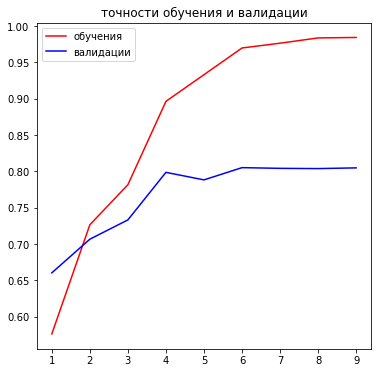

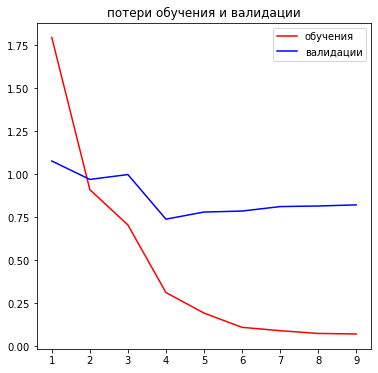

In [21]:
plt.rcParams["figure.figsize"] = (6,6)

plt.title("точности обучения и валидации")
acc = history.history["acc"]
epochs = range(1, len(acc) + 1)
val_acc = history.history["val_acc"]
plt.plot(epochs, acc, "red", label='обучения')
plt.plot(epochs, val_acc, "blue", label="валидации")
plt.legend()

plt.figure()
plt.title("потери обучения и валидации")
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.plot(epochs, loss, "red", label="обучения")
plt.plot(epochs, val_loss, "blue", label="валидации")
plt.legend()

plt.show()

In [22]:
print(max(val_acc))

0.80498868227005


100.00% 	 pomeranian
0.00% 	 chihuahua
0.00% 	 samoyed
0.00% 	 chow
0.00% 	 norwich_terrier


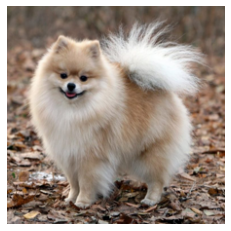

In [27]:
download_and_predict("https://i.imgur.com/QzxTOG1.jpg",
                     "pomeranian.jpg")

99.93% 	 doberman
0.04% 	 tan_coonhound
0.03% 	 miniature_pinscher
0.00% 	 toy_terrier
0.00% 	 kelpie


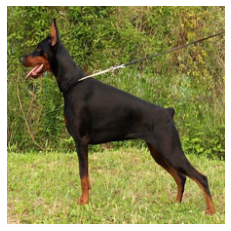

In [28]:
download_and_predict("https://upload.wikimedia.org/wikipedia/commons/7/7a/European_Dobermann.jpg",
                     "doberman.jpg")

99.97% 	 pug
0.02% 	 bull_mastiff
0.00% 	 brabancon_griffon
0.00% 	 french_bulldog
0.00% 	 norwegian_elkhound


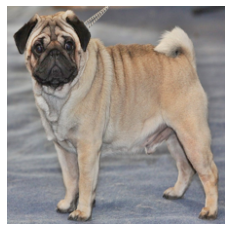

In [29]:
download_and_predict("https://upload.wikimedia.org/wikipedia/commons/f/f0/Mops_oct09_cropped2.jpg",
                     "pug.jpg")

98.87% 	 chow
0.53% 	 samoyed
0.43% 	 keeshond
0.09% 	 pomeranian
0.03% 	 siberian_husky


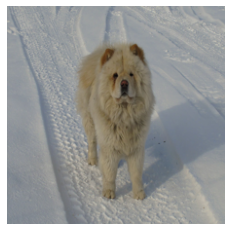

In [30]:
download_and_predict("https://upload.wikimedia.org/wikipedia/commons/c/c7/ChowChow1.jpg",
                     "chow.jpg")

100.00% 	 keeshond
0.00% 	 chow
0.00% 	 pomeranian
0.00% 	 groenendael
0.00% 	 shetland_sheepdog


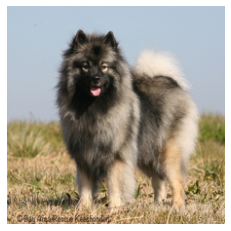

In [31]:
download_and_predict("https://i.imgur.com/LXNeEq7.jpg",
                     "keeshound.jpg")

## Предобученная модель AlexNet

In [7]:
model=Sequential()

# 1st Convolutional Layer
model.add(Conv2D(filters=96,kernel_size=(11,11),strides=(4,4),padding="valid",activation="relu",input_shape=(224, 224, 3)))
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
model.add(BatchNormalization())

# 2nd Convolutional Layer
model.add(Conv2D(filters=256,kernel_size=(5,5),strides=(1,1),padding="valid",activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
model.add(BatchNormalization())

# 3rd Convolutional Layer
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

# 4th Convolutional Layer
model.add(Conv2D(filters=384,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))

# 5th Convolutional Layer
model.add(Conv2D(filters=256,kernel_size=(3,3),strides=(1,1),padding="valid",activation="relu"))
model.add(MaxPooling2D(pool_size=(3,3),strides=(2,2)))
model.add(BatchNormalization())

# Passing it to a dense layer
model.add(Flatten())
# 1st Dense Layer
model.add(Dense(4096,input_shape=(224, 224, 3),activation="relu"))
model.add(Dropout(0.4))
model.add(BatchNormalization())

# 2nd Dense Layer
model.add(Dense(4096,activation="relu"))
model.add(Dropout(0.4))
model.add(BatchNormalization())

#output layer
model.add(Dense(num_classes,activation="softmax"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 54, 54, 96)        34944     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 26, 26, 96)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 26, 26, 96)        384       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 22, 22, 256)       614656    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 10, 10, 256)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 10, 10, 256)       1024      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 384)        

In [9]:
model.compile(optimizer="adam",
              loss="categorical_crossentropy",
              metrics=["acc"])

checkpoint = ModelCheckpoint("dog-breed-classifier-alexnet.h5", 
                             monitor="val_acc", 
                             verbose=1, 
                             save_best_only=True, 
                             mode="max")

reduce_lr = ReduceLROnPlateau(monitor="val_loss", 
                              factor=0.2,
                              patience=1, 
                              verbose=1, 
                              mode="min",
                              min_delta=0.0001, 
                              cooldown=2, 
                              min_lr=1e-7)

early_stop = EarlyStopping(monitor="val_loss", 
                           mode="min",
                           patience=5)

In [10]:
%%time

history = model.fit(train_gen,
                    steps_per_epoch=len(train_gen), 
                    validation_data=valid_gen, 
                    validation_steps=len(valid_gen),
                    epochs=20,
                    callbacks=[checkpoint, reduce_lr, early_stop])

Epoch 1/20
547/547 [==============================] - 650s 1s/step - loss: 5.9600 - acc: 0.0214 - val_loss: 5.1997 - val_acc: 0.0262

Epoch 00001: val_acc improved from -inf to 0.02624, saving model to dog-breed-classifier-alexnet.h5
Epoch 2/20
547/547 [==============================] - 106s 194ms/step - loss: 5.6408 - acc: 0.0314 - val_loss: 6.4608 - val_acc: 0.0454

Epoch 00002: val_acc improved from 0.02624 to 0.04535, saving model to dog-breed-classifier-alexnet.h5

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
Epoch 3/20
547/547 [==============================] - 106s 194ms/step - loss: 4.8514 - acc: 0.0416 - val_loss: 4.1531 - val_acc: 0.0677

Epoch 00003: val_acc improved from 0.04535 to 0.06770, saving model to dog-breed-classifier-alexnet.h5
Epoch 4/20
547/547 [==============================] - 107s 195ms/step - loss: 4.5246 - acc: 0.0541 - val_loss: 4.2464 - val_acc: 0.0596

Epoch 00004: val_acc did not improve from 0.06770

Epoch 00004: Red

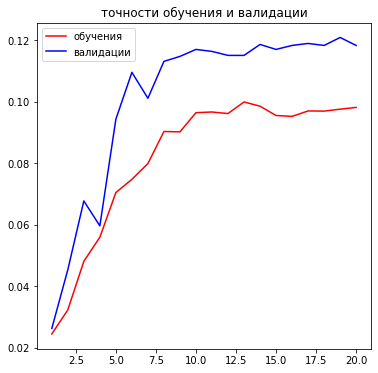

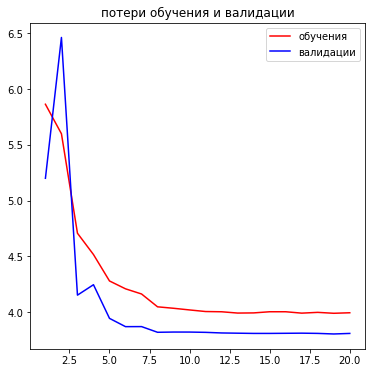

In [11]:
plt.rcParams["figure.figsize"] = (6,6)

plt.title("точности обучения и валидации")
acc = history.history["acc"]
epochs = range(1, len(acc) + 1)
val_acc = history.history["val_acc"]
plt.plot(epochs, acc, "red", label='обучения')
plt.plot(epochs, val_acc, "blue", label="валидации")
plt.legend()

plt.figure()
plt.title("потери обучения и валидации")
loss = history.history["loss"]
val_loss = history.history["val_loss"]
plt.plot(epochs, loss, "red", label="обучения")
plt.plot(epochs, val_loss, "blue", label="валидации")
plt.legend()

plt.show()

In [15]:
print(max(val_acc))

0.12082928419113159


100.00% 	 japanese_spaniel
0.00% 	 papillon
0.00% 	 african_hunting_dog
0.00% 	 boston_bull
0.00% 	 kerry_blue_terrier


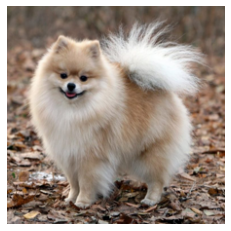

In [14]:
download_and_predict("https://i.imgur.com/QzxTOG1.jpg",
                     "pomeranian.jpg")